In [1]:
# https://www.kaggle.com/datasets/novandraanugrah/xauusd-gold-price-historical-data-2004-2024


#https://huggingface.co/ibm-granite/granite-timeseries-patchtst

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("novandraanugrah/xauusd-gold-price-historical-data-2004-2024")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'xauusd-gold-price-historical-data-2004-2024' dataset.
Path to dataset files: /kaggle/input/xauusd-gold-price-historical-data-2004-2024


In [20]:
# Install dependencies
!pip install --upgrade pip
!pip install "transformers>=4.45.0" datasets accelerate huggingface_hub torch --quiet
!pip install git+https://github.com/IBM/tsfm.git --quiet

# Login to Hugging Face
from huggingface_hub import login
login(token="YOUR_HF_TOKEN")  # Replace your token

# Load and preprocess dataset
import pandas as pd
import os
import numpy as np

DATA_DIR = "/kaggle/input/xauusd-gold-price-historical-data-2004-2024"

# Load CSVs and concatenate
all_dfs = [pd.read_csv(os.path.join(DATA_DIR, f), sep=';', quotechar='"') for f in os.listdir(DATA_DIR) if f.endswith('.csv')]
df = pd.concat(all_dfs, ignore_index=True)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Aggregate daily close prices
df_daily = df[["Date", "Close"]].set_index("Date").resample("D").last().dropna().reset_index()
print(f"Daily data shape: {df_daily.shape}")
print(f"Date range: {df_daily['Date'].min()} to {df_daily['Date'].max()}")

# Parameters - FIXED: Make sure sequence_length matches model config
sequence_length = 32   # Changed to match PatchTST default
patch_size = 8         # Should divide sequence_length exactly (32/8=4)
prediction_length = 1  # Single step prediction

print(f"Sequence length: {sequence_length}, Patch size: {patch_size}")

# Prepare sliding windows
values = df_daily["Close"].tolist()
past_values, labels = [], []
for i in range(len(values) - sequence_length - prediction_length + 1):
    past_values.append(values[i : i + sequence_length])
    labels.append(values[i + sequence_length : i + sequence_length + prediction_length])

print(f"Total sequences: {len(past_values)}")

# Train/test split
split_idx = int(0.8 * len(past_values))
train_data = { "past_values": past_values[:split_idx], "labels": labels[:split_idx] }
test_data = { "past_values": past_values[split_idx:], "labels": labels[split_idx:] }

print(f"Train sequences: {len(train_data['past_values'])}, Test sequences: {len(test_data['past_values'])}")

import torch
from torch.utils.data import Dataset, DataLoader

class GoldDataset(Dataset):
    def __init__(self, data):
        self.x = data["past_values"]
        self.y = data["labels"]
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        x = torch.tensor(self.x[idx], dtype=torch.float32).unsqueeze(-1)  # shape: (seq_len, 1)
        y = torch.tensor(self.y[idx], dtype=torch.float32)              # shape: (prediction_length,)
        return x, y

train_loader = DataLoader(GoldDataset(train_data), batch_size=16, shuffle=True)
test_loader = DataLoader(GoldDataset(test_data), batch_size=16)

from transformers import PatchTSTConfig, PatchTSTForPrediction

# FIXED: Configuration matches our sequence length
config = PatchTSTConfig(
    sequence_length=sequence_length,  # This must match input sequence length
    patch_size=patch_size,
    prediction_length=prediction_length,
    num_input_channels=1,
    # Optional: You can customize other parameters
    d_model=64,
    num_attention_heads=4,
    num_layers=3,
)

print("Model configuration:")
print(f"Sequence length: {config.sequence_length}")
print(f"Patch size: {config.patch_size}")
print(f"Prediction length: {config.prediction_length}")

model = PatchTSTForPrediction(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# Verify input shapes
sample_batch = next(iter(train_loader))
x_sample, y_sample = sample_batch
print(f"Sample input shape: {x_sample.shape}")  # Should be [batch, seq_len, channels]
print(f"Sample target shape: {y_sample.shape}") # Should be [batch, prediction_length]

import torch.nn as nn
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
num_epochs = 5

print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        # Debug: Print shapes before forward pass
        if batch_idx == 0 and epoch == 0:
            print(f"Input shape to model: {x.shape}")
            print(f"Target shape: {y.shape}")

        optimizer.zero_grad()
        outputs = model(past_values=x)
        preds = outputs.prediction_outputs

        # Handle different possible output shapes
        if preds.dim() == 3:
            preds = preds.squeeze(-1)
        if y.dim() == 2 and y.shape[-1] == 1:
            y = y.squeeze(-1)

        # Debug: Print shapes before loss calculation
        if batch_idx == 0 and epoch == 0:
            print(f"Prediction shape: {preds.shape}")
            print(f"Final target shape: {y.shape}")

        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss / len(train_loader):.4f}")

# Evaluation
model.eval()
preds, targets = [], []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(past_values=x)
        pred = outputs.prediction_outputs

        if pred.dim() == 3:
            pred = pred.squeeze(-1)
        if y.dim() == 2 and y.shape[-1] == 1:
            y = y.squeeze(-1)

        preds.extend(pred.cpu().numpy())
        targets.extend(y.cpu().numpy())

preds = np.array(preds)
targets = np.array(targets)
mse = np.mean((preds - targets)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(preds - targets))

print(f"Test MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")

# Save model
model.save_pretrained("./patchtst-gold-univariate")
print("Model saved successfully!")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Daily data shape: (6541, 2)
Date range: 2004-06-01 00:00:00 to 2025-10-01 00:00:00
Sequence length: 32, Patch size: 8
Total sequences: 6509
Train sequences: 5207, Test sequences: 1302
Model configuration:
Sequence length: 32
Patch size: 8
Prediction length: 1
Using device: cuda
Sample input shape: torch.Size([16, 32, 1])
Sample target shape: torch.Size([16, 1])
Starting training...
Input shape to model: torch.Size([16, 32, 1])
Target shape: torch.Size([16, 1])
Prediction shape: torch.Size([16, 1])
Final target shape: torch.Size([16])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/5 - Loss: 282839.1146
Epoch 2/5 - Loss: 279251.0558
Epoch 3/5 - Loss: 276276.8099
Epoch 4/5 - Loss: 276519.6437
Epoch 5/5 - Loss: 277659.6219
Test MSE: 366802.9062 | RMSE: 605.6426 | MAE: 442.6134
Model saved successfully!


=== MODEL CONFIGURATION DEBUG ===
Model sequence_length: 32
Model patch_size: 8
Model prediction_length: 1

=== INPUT SHAPE DEBUG ===
Test batch input shape: torch.Size([16, 32, 1])
Test batch target shape: torch.Size([16, 1])
Model output shape: torch.Size([16, 1, 1])

TESTING FUTURE PREDICTION
Historical data length: 6541
Last test sequence length: 32

Attempting to predict 30 future steps...

Using recent data from index 6509 to 6540
Current window length: 32
Latest price: 3866.29
Successfully generated 30 future predictions

Generated 30 future predictions
Prediction range: 3205.94 to 2239.75


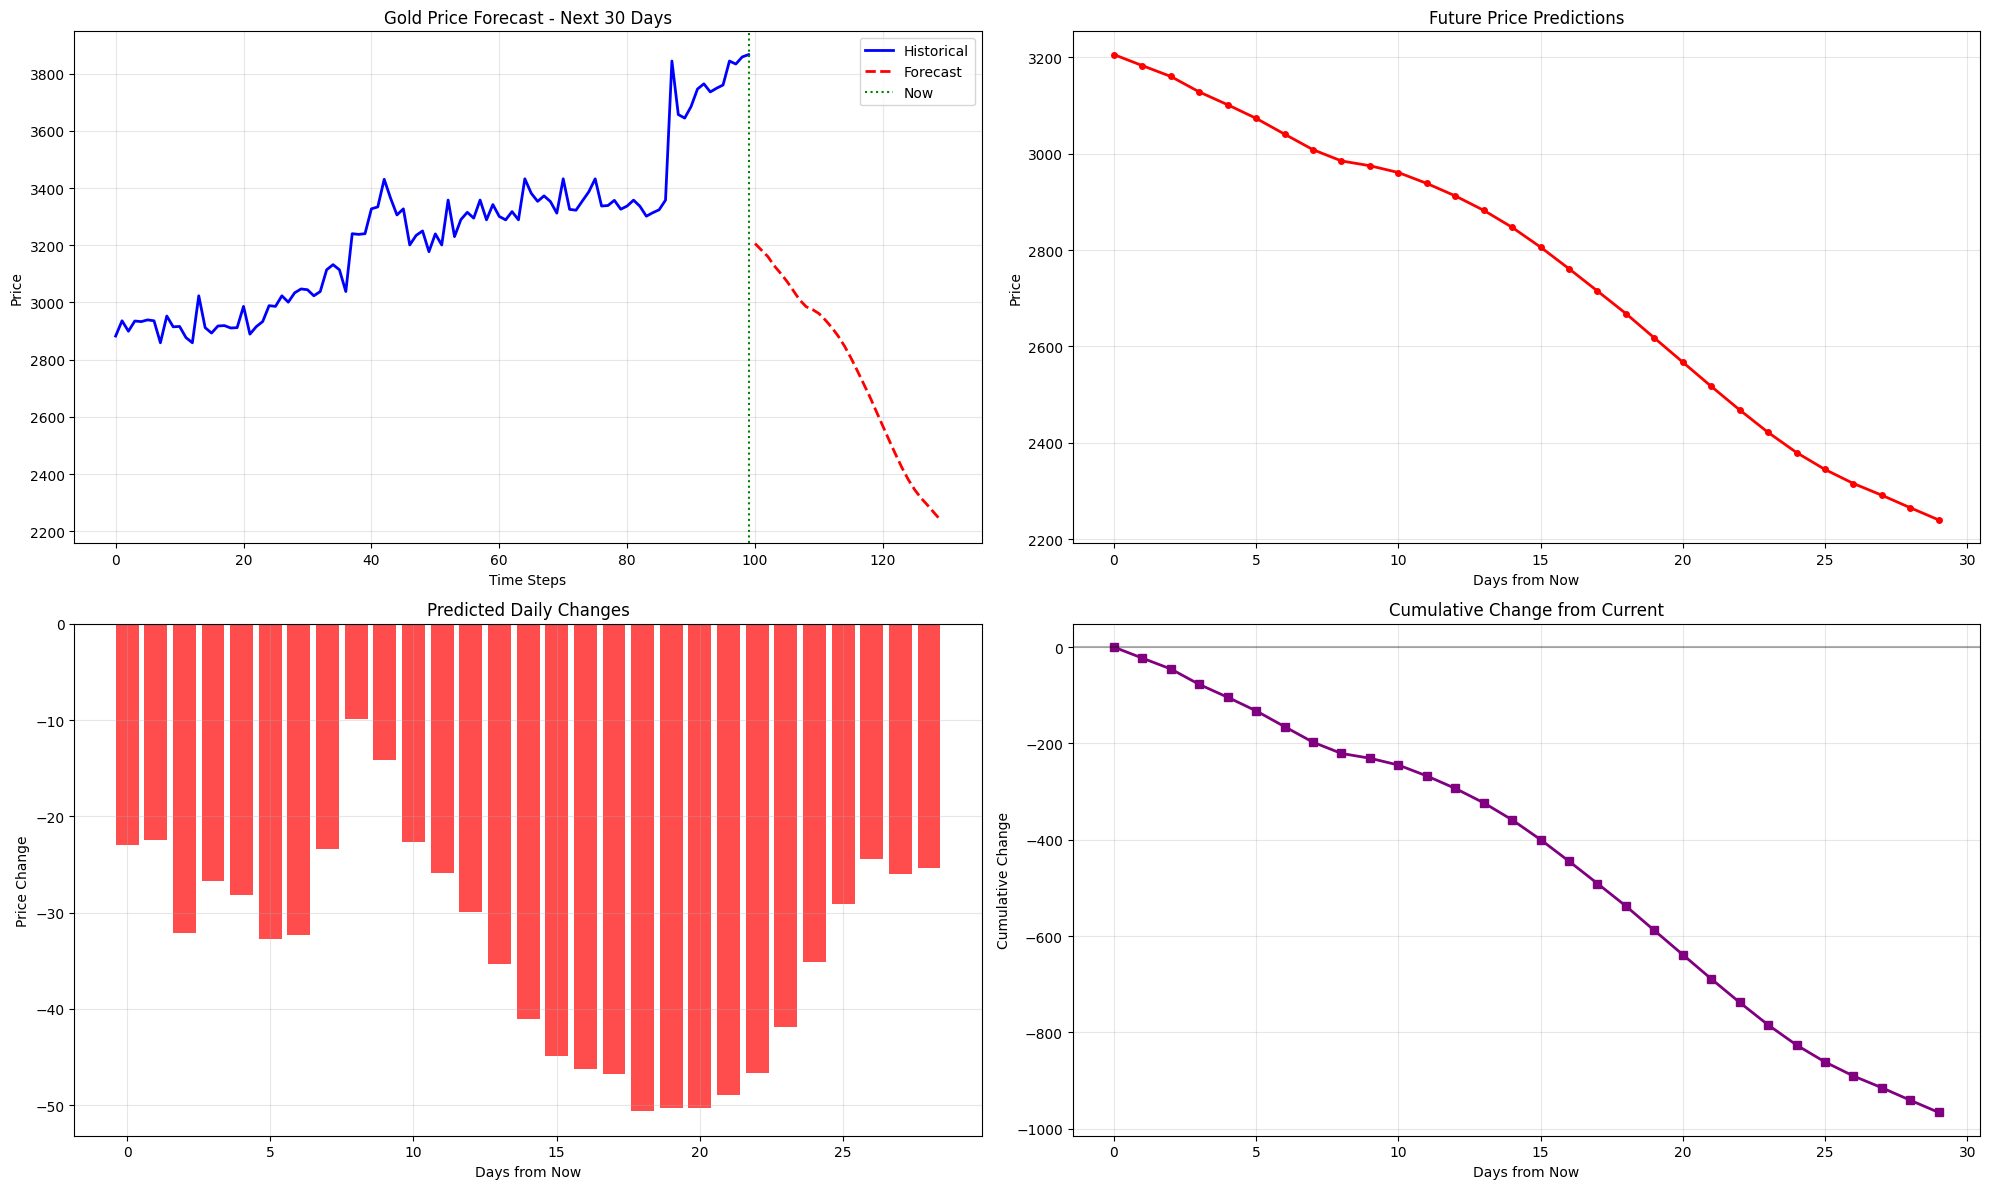


PREDICTION SUMMARY
Current Price: 3866.29
Predicted Price in 30 days: 2239.75
Total Change: -966.19 (-30.14%)
Average Daily Change: -33.3168
Trend: BEARISH


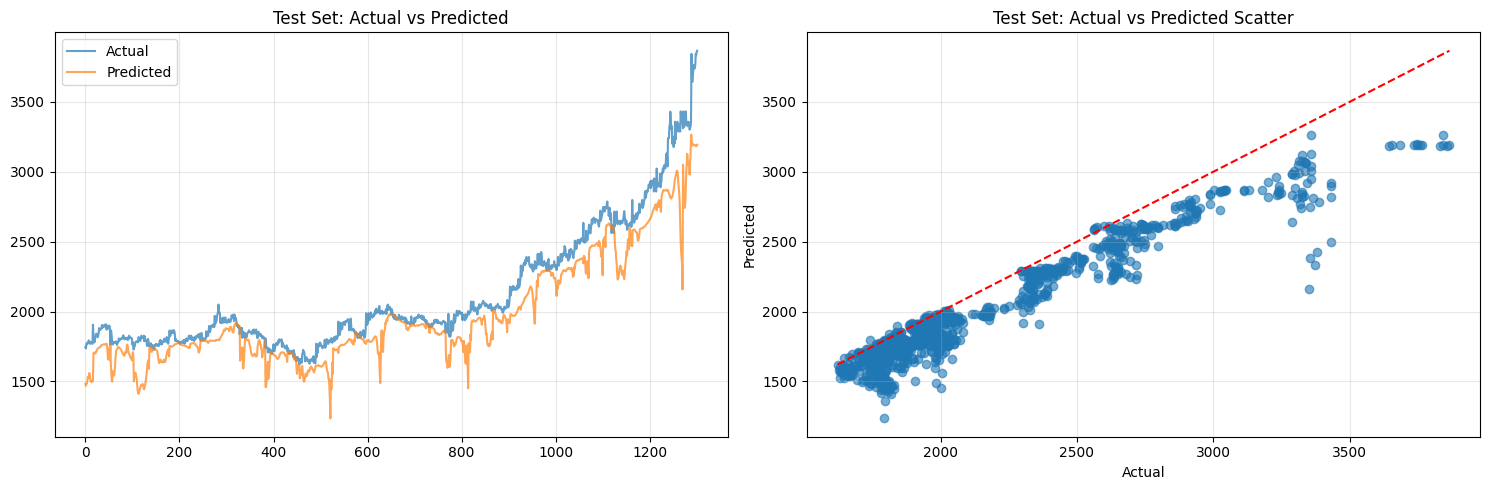


Test Set Performance:
MAE:  442.6134
RMSE: 605.6426


In [24]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# First, let's debug the model configuration and input shapes
print("=== MODEL CONFIGURATION DEBUG ===")
print(f"Model sequence_length: {model.config.sequence_length}")
print(f"Model patch_size: {model.config.patch_size}")
print(f"Model prediction_length: {model.config.prediction_length}")

# Test with a single batch to see what's happening
model.eval()
with torch.no_grad():
    # Get one batch from test loader
    test_batch_x, test_batch_y = next(iter(test_loader))
    print(f"\n=== INPUT SHAPE DEBUG ===")
    print(f"Test batch input shape: {test_batch_x.shape}")  # Should be [batch, seq_len, channels]
    print(f"Test batch target shape: {test_batch_y.shape}")

    # Test model forward pass
    test_batch_x = test_batch_x.to(device)
    outputs = model(past_values=test_batch_x)
    print(f"Model output shape: {outputs.prediction_outputs.shape}")

# Fixed prediction function with detailed debugging
def predict_future_with_debug(model, initial_sequence, steps=30, device='cpu'):
    """Predict future prices with detailed debugging"""
    model.eval()
    future_predictions = []

    # Debug initial sequence
    print(f"\n=== FUTURE PREDICTION DEBUG ===")
    print(f"Initial sequence length: {len(initial_sequence)}")
    print(f"Required sequence length: {model.config.sequence_length}")

    # Ensure we have the right sequence length
    if len(initial_sequence) != model.config.sequence_length:
        print(f"WARNING: Initial sequence length {len(initial_sequence)} doesn't match required {model.config.sequence_length}")
        # Take the last N elements to match required length
        initial_sequence = initial_sequence[-model.config.sequence_length:]
        print(f"Adjusted initial sequence length: {len(initial_sequence)}")

    current_sequence = initial_sequence.copy()

    with torch.no_grad():
        for step in range(steps):
            print(f"\nStep {step + 1}:")
            print(f"Current sequence length: {len(current_sequence)}")

            # Take the last N elements where N = sequence_length
            input_sequence = current_sequence[-model.config.sequence_length:]
            print(f"Input sequence length for model: {len(input_sequence)}")

            # Convert to tensor with correct shape
            input_tensor = torch.tensor(input_sequence, dtype=torch.float32)
            print(f"Input tensor shape before unsqueeze: {input_tensor.shape}")

            # Add batch dimension and channel dimension
            input_tensor = input_tensor.unsqueeze(0).unsqueeze(-1)  # Shape: [1, seq_len, 1]
            print(f"Input tensor shape after unsqueeze: {input_tensor.shape}")

            # Move to device
            input_tensor = input_tensor.to(device)

            try:
                # Make prediction
                outputs = model(past_values=input_tensor)
                next_pred = outputs.prediction_outputs.cpu().numpy()
                print(f"Raw output shape: {outputs.prediction_outputs.shape}")
                print(f"Raw output: {outputs.prediction_outputs}")

                # Handle different output shapes
                if next_pred.ndim == 3:
                    next_pred = next_pred[0, 0, 0]  # [batch, pred_length, channels]
                elif next_pred.ndim == 2:
                    next_pred = next_pred[0, 0]     # [batch, pred_length]
                else:
                    next_pred = next_pred[0]        # [pred_length]

                print(f"Next prediction: {next_pred:.4f}")

                future_predictions.append(next_pred)

                # Update sequence with new prediction
                current_sequence = np.append(current_sequence, next_pred)

            except Exception as e:
                print(f"Error at step {step}: {e}")
                print(f"Input tensor shape: {input_tensor.shape}")
                break

    return np.array(future_predictions)

# Let's also create a simpler, more robust version
def predict_future_robust(model, historical_prices, steps=30, device='cpu'):
    """Robust future prediction using the most recent data"""
    model.eval()
    future_predictions = []

    # Use the most recent sequence_length points
    recent_data = historical_prices[-model.config.sequence_length:]
    current_window = recent_data.copy()

    print(f"\nUsing recent data from index {len(historical_prices) - model.config.sequence_length} to {len(historical_prices) - 1}")
    print(f"Current window length: {len(current_window)}")
    print(f"Latest price: {current_window[-1]:.2f}")

    with torch.no_grad():
        for step in range(steps):
            # Prepare input tensor
            input_tensor = torch.tensor(current_window, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)

            # Verify input shape
            if input_tensor.shape[1] != model.config.sequence_length:
                print(f"Error: Input sequence length {input_tensor.shape[1]} doesn't match model {model.config.sequence_length}")
                break

            # Make prediction
            outputs = model(past_values=input_tensor)
            prediction = outputs.prediction_outputs

            # Extract the prediction value
            if prediction.dim() == 3:
                next_price = prediction[0, 0, 0].item()
            else:
                next_price = prediction[0, 0].item()

            future_predictions.append(next_price)

            # Update window: remove oldest, add new prediction
            current_window = np.append(current_window[1:], next_price)

    return np.array(future_predictions)

# Test both approaches
print("\n" + "="*50)
print("TESTING FUTURE PREDICTION")
print("="*50)

# Get appropriate historical data
historical_prices = df_daily["Close"].values
last_sequence = test_data["past_values"][-1]  # This should be length 32

print(f"Historical data length: {len(historical_prices)}")
print(f"Last test sequence length: {len(last_sequence)}")

# Try the robust approach first
future_steps = 30
print(f"\nAttempting to predict {future_steps} future steps...")

try:
    future_predictions = predict_future_robust(model, historical_prices, steps=future_steps, device=device)
    print(f"Successfully generated {len(future_predictions)} future predictions")
except Exception as e:
    print(f"Error in robust prediction: {e}")
    # Fall back to debug version
    print("Trying debug version...")
    future_predictions = predict_future_with_debug(model, last_sequence, steps=future_steps, device=device)

# If we have predictions, create visualizations
if len(future_predictions) > 0:
    print(f"\nGenerated {len(future_predictions)} future predictions")
    print(f"Prediction range: {future_predictions[0]:.2f} to {future_predictions[-1]:.2f}")

    # Create comprehensive visualization
    def create_comprehensive_forecast_plot(historical_prices, future_predictions, last_n=100):
        """Create a comprehensive forecast visualization"""
        fig, axes = plt.subplots(2, 2, figsize=(20, 12))

        # Plot 1: Historical data with future predictions
        historical_to_plot = historical_prices[-last_n:]
        historical_indices = range(len(historical_to_plot))
        future_indices = range(len(historical_to_plot), len(historical_to_plot) + len(future_predictions))

        axes[0, 0].plot(historical_indices, historical_to_plot, 'b-', linewidth=2, label='Historical')
        axes[0, 0].plot(future_indices, future_predictions, 'r--', linewidth=2, label='Forecast')
        axes[0, 0].axvline(x=len(historical_to_plot)-1, color='green', linestyle=':', label='Now')
        axes[0, 0].set_title(f'Gold Price Forecast - Next {len(future_predictions)} Days')
        axes[0, 0].set_xlabel('Time Steps')
        axes[0, 0].set_ylabel('Price')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Plot 2: Future predictions only
        axes[0, 1].plot(future_predictions, 'ro-', linewidth=2, markersize=4)
        axes[0, 1].set_title('Future Price Predictions')
        axes[0, 1].set_xlabel('Days from Now')
        axes[0, 1].set_ylabel('Price')
        axes[0, 1].grid(True, alpha=0.3)

        # Plot 3: Daily changes
        daily_changes = np.diff(future_predictions)
        colors = ['green' if x > 0 else 'red' for x in daily_changes]
        axes[1, 0].bar(range(len(daily_changes)), daily_changes, color=colors, alpha=0.7)
        axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[1, 0].set_title('Predicted Daily Changes')
        axes[1, 0].set_xlabel('Days from Now')
        axes[1, 0].set_ylabel('Price Change')
        axes[1, 0].grid(True, alpha=0.3)

        # Plot 4: Cumulative change
        cumulative_change = future_predictions - future_predictions[0]
        axes[1, 1].plot(cumulative_change, 'purple', linewidth=2, marker='s')
        axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[1, 1].set_title('Cumulative Change from Current')
        axes[1, 1].set_xlabel('Days from Now')
        axes[1, 1].set_ylabel('Cumulative Change')
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return fig

    # Generate the plot
    fig = create_comprehensive_forecast_plot(historical_prices, future_predictions)

    # Print prediction summary
    print("\n" + "="*50)
    print("PREDICTION SUMMARY")
    print("="*50)
    print(f"Current Price: {historical_prices[-1]:.2f}")
    print(f"Predicted Price in {future_steps} days: {future_predictions[-1]:.2f}")

    total_change = future_predictions[-1] - future_predictions[0]
    percent_change = (total_change / future_predictions[0]) * 100
    print(f"Total Change: {total_change:+.2f} ({percent_change:+.2f}%)")

    avg_daily_change = np.mean(np.diff(future_predictions))
    print(f"Average Daily Change: {avg_daily_change:+.4f}")

    if total_change > 0:
        trend = "BULLISH"
    else:
        trend = "BEARISH"
    print(f"Trend: {trend}")
    print("="*50)

else:
    print("No predictions were generated due to errors")

# Alternative approach: Use the model for one-step predictions and analyze trends
def analyze_model_predictions(model, test_loader, device):
    """Analyze model predictions on test set"""
    model.eval()
    all_predictions = []
    all_actuals = []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(past_values=x)
            predictions = outputs.prediction_outputs

            if predictions.dim() == 3:
                predictions = predictions.squeeze(-1)

            all_predictions.extend(predictions.cpu().numpy())
            all_actuals.extend(y.squeeze(-1).cpu().numpy())

    return np.array(all_predictions), np.array(all_actuals)

# Get test set predictions for analysis
test_predictions, test_actuals = analyze_model_predictions(model, test_loader, device)

# Plot test set performance
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(test_actuals, label='Actual', alpha=0.7)
plt.plot(test_predictions, label='Predicted', alpha=0.7)
plt.title('Test Set: Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(test_actuals, test_predictions, alpha=0.6)
plt.plot([test_actuals.min(), test_actuals.max()], [test_actuals.min(), test_actuals.max()], 'r--')
plt.title('Test Set: Actual vs Predicted Scatter')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and print test metrics
test_mae = np.mean(np.abs(test_predictions - test_actuals))
test_rmse = np.sqrt(np.mean((test_predictions - test_actuals)**2))
print(f"\nTest Set Performance:")
print(f"MAE:  {test_mae:.4f}")
print(f"RMSE: {test_rmse:.4f}")